Loading dependecies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import scipy.io
import scipy.signal
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

Extracts n segments of raw EEG from the provided data.

To do so, the function selects n values from `data.t` array, which contains timestamps of the trial beginning. If shuffle=True, then the function randomly selects n trials, otherwise first n values from `data.t` are selected.

For each timestamp, function extracts corresponding block 900 values of raw EEG data with 32 channels and the trial label (1 or 0 - target or non-target).

The function returns `segments(n, 900, 32), y(n), t(n)`.

In [ ]:
def raw_eeg_segments(raw_eeg, t):

    selected_channels = [12, 16, 33, 34, 28, 7, 29, 44, 41, 25, 11, 42, 14, 5, 17, 21]
    for i in range(len(selected_channels)):
        selected_channels[i] -= 1

    raw_eeg = raw_eeg[:, selected_channels]

    n = t.shape[0]
    
    segments = np.zeros((n, 900, raw_eeg.shape[1]))
    for i in range(n):
        segments[i] = raw_eeg[t[i]-100:t[i]+800]

    return segments

This function filters the given segments with 5-th order Butterworth bandpass filter between 0.5 - 40 Hz.

In [ ]:
def filter(segments, show=False):
    sos = scipy.signal.butter(5, (0.5, 40), btype='bandpass', output='sos', fs=1000)
    filtered = scipy.signal.sosfilt(sos, segments, axis=1)

    if show:
        plt.figure(figsize=(12, 8))
        plt.plot(range(-100, 800), segments[0,:,0])
        plt.plot(range(-100, 800), filtered[0,:,0])
        plt.legend(['Original', 'Filtered'])
        plt.grid('on')
        plt.show()

    return filtered

As you remember, the `raw_eeg_segments()` was extracting segments with 900 values for 32 channels. First 100 values are used to perform baseline average for the rest 800 samples. This function subtracts the average value of first 100 elements from the rest 800 elements in each segment. The segment size is reduced from 900 to 800.

In [ ]:
def baseline_correct(filtered, show=False):
    corrected = np.empty((filtered.shape[0], 800, filtered.shape[2]))

    for i in range(filtered.shape[0]):
        corrected[i] = filtered[i,100:,:] - filtered[i,:100,:].mean(axis=0)
    
    if show:
        plt.figure(figsize=(12, 8))
        plt.plot(range(-100, 800), filtered[0,:,0])
        plt.plot(range(0, 800), corrected[0,:,0])
        plt.grid('on')
        plt.legend(['Filtered', 'Filtered and baseline corrected'])
        plt.show()

    return corrected

The segments are downsampled from 800 to 8 samples in this function. Each block of 100 samples in the segment is averaged. 

In [ ]:
def average(corrected, show=False):

    x = np.empty((corrected.shape[0], 8, corrected.shape[2]))

    for i in range(corrected.shape[0]):
        for j in range(corrected.shape[1] // 100):
            x[i, j] = corrected[i, j*100:(j+1)*100].mean(axis=0)

    if show:
        plt.figure(figsize=(12, 8))
        plt.plot(range(0, 800), corrected[0,:,0])
        plt.plot(range(50,800, 100), x[0,:,0], marker='o')
        plt.grid('on')
        plt.legend(['Filtered and baseline corrected',
                    'Filtered, corrected, averaged'],
                loc='best')
        plt.title('ERP EEG preprocessing')
        plt.xlabel('Time (ms)')
        plt.xticks(ticks=range(-100,801, 100))
        plt.savefig('/content/ERP_EEG_preprocessing.png')
        plt.show()

    return x

All of the above operations are combined in this function. It takes data from `scipy.io.loadmat(filename)['EEG_ERP_train']` to extract `n` samples of data. The function returns two numpy arrays: `x` with the shape (n, 256) and `y` with the shape (n, 1).

In [ ]:
def get_erp_features(x, y, t, show=False):
    segments = raw_eeg_segments(x, t)
    filtered = filter(segments)
    corrected = baseline_correct(filtered)
    x = average(corrected)

    x = x[:, 1:7, :]

    if show:
        plt.figure(figsize=(12, 8))
        plt.plot(range(-100, 800), segments[0, :, 0])
        plt.plot(range(-100, 800), filtered[0, :, 0])
        plt.plot(range(0, 800), corrected[0,:,0])
        plt.plot(range(150,700, 100), x[0,:,0], marker='o')
        plt.grid('on')
        plt.legend(['Raw EEG',
                    'Bandpass filtered'
                    'Filtered and baseline corrected',
                    'Filtered, corrected, averaged'],
                loc='best')
        plt.title('ERP EEG preprocessing (one channel)')
        plt.xlabel('Time (ms)')
        plt.xticks(ticks=range(-100,801, 100))
        plt.savefig('/content/0. ERP_EEG_preprocessing.png')
        plt.show()

        plt.figure(figsize=(12, 8))
        plt.plot(range(-100, 800), segments[0, :, :])
        plt.grid('on')
        plt.title('Raw ERP EEG')
        plt.xlabel('Time (ms)')
        plt.xticks(ticks=range(-100,801, 100))
        plt.savefig('/content/1. ERP_EEG_raw_eeg.png')
        plt.show()
        
        plt.figure(figsize=(12, 8))
        plt.plot(range(-100, 800), filtered[0, :, :])
        plt.grid('on')
        plt.title('Bandpass Filtered ERP EEG')
        plt.xlabel('Time (ms)')
        plt.xticks(ticks=range(-100,801, 100))
        plt.savefig('/content/2. ERP_EEG_bandpass.png')
        plt.show()

        plt.figure(figsize=(12, 8))
        plt.plot(range(0, 800), corrected[0,:,:])
        plt.grid('on')
        plt.title('Baseline corrected ERP EEG')
        plt.xlabel('Time (ms)')
        plt.xticks(ticks=range(-100,801, 100))
        plt.savefig('/content/3. ERP_EEG_baselineCorrected.png')
        plt.show()

        plt.figure(figsize=(12, 8))
        plt.plot(range(150,700, 100), x[0,:,:], marker='o')
        plt.grid('on')
        plt.title('ERP EEG features')
        plt.xlabel('Time (ms)')
        plt.xticks(ticks=range(-100,801, 100))
        plt.savefig('/content/4. ERP_EEG_features.png')
        plt.show()

    x = x.reshape(t.shape[0], -1)


    return x, y

In [ ]:
acc = np.zeros((3, 50))
explorer = pathlib.Path('/content/drive/My Drive/BCI/data/').glob('**/*ERP.mat')

for filename in explorer:
    
    session = int(filename.name[4:6])
    subj = int(filename.name[11:13])

    print('{:02d} {:02d}'.format(session, subj), end='')

    data = scipy.io.loadmat(filename)

    train_data = data['EEG_ERP_train']
    test_data = data['EEG_ERP_test']

    train_x = train_data['x'][0][0]
    train_y = train_data['y_dec'][0][0].reshape(-1) - 1
    train_t = train_data['t'][0][0].reshape(-1)

    test_x = test_data['x'][0][0]
    test_y = test_data['y_dec'][0][0].reshape(-1) - 1
    test_t = test_data['t'][0][0].reshape(-1)

    # n = 500

    # indices = np.empty(n)
    # indices = np.random.permutation(range(train_t.size))[:n]

    # train_y = train_y[indices]
    # train_t = train_t[indices]


    train_x, train_y = get_erp_features(train_x, train_y, train_t)
    test_x, test_y = get_erp_features(test_x, test_y, test_t)



    classifier = LDA()
    classifier.fit(train_x, train_y)


    predictions = classifier.predict(test_x)

    
    acc[session, subj] = np.sum(predictions == test_y) / test_y.shape[0]
    print(': {:.2f}%'.format(acc[session, subj]*100))


02 01: 86.57%
02 03: 91.25%
02 02: 94.44%
02 04: 92.08%
02 05: 84.68%
02 08: 87.50%
02 06: 89.26%
02 07: 92.13%
02 09: 84.21%
02 10: 88.94%
01 03: 90.74%
01 02: 95.97%
01 01: 84.68%
01 04: 84.44%
01 05: 87.82%
01 06: 91.11%
01 07: 92.31%
01 08: 85.37%
01 09: 87.64%
01 10: 87.64%


In [ ]:
with open('/content/drive/My Drive/BCI/src/ERP_16_features_LDA.txt', 'w') as file:
    for i in range(1,3):
        for j in range(1, 11):
            print('Sesssion {:2d}, Subject {:2d}:\t{:.4f}'.format(
                i, j, acc[i,j]
            ), file=file)
    print('\nAverage:\t{:.4f}'.format(acc[1:3,1:11].mean()), file=file)

(1980, 96)


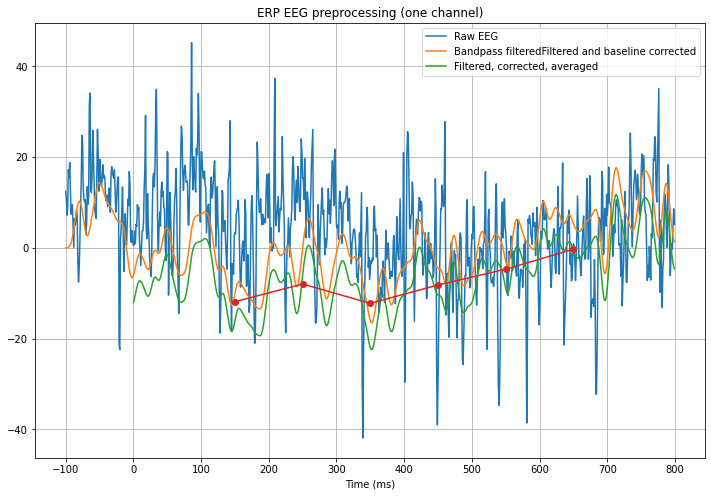

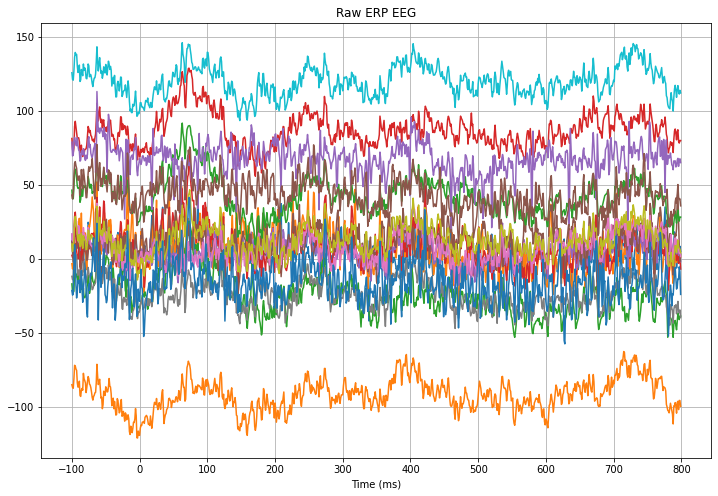

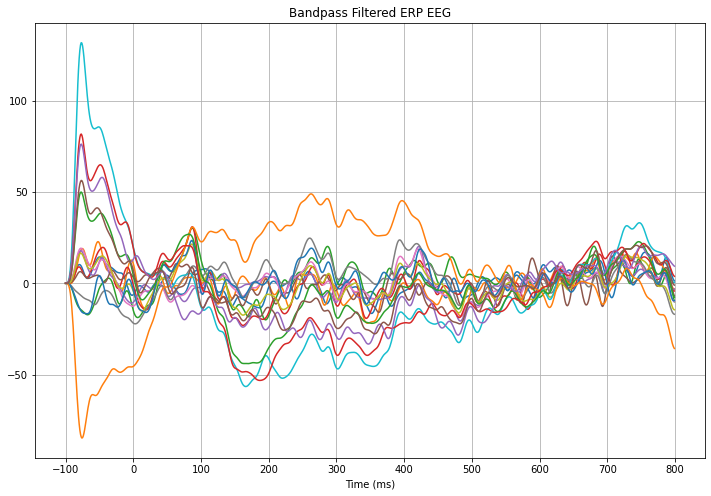

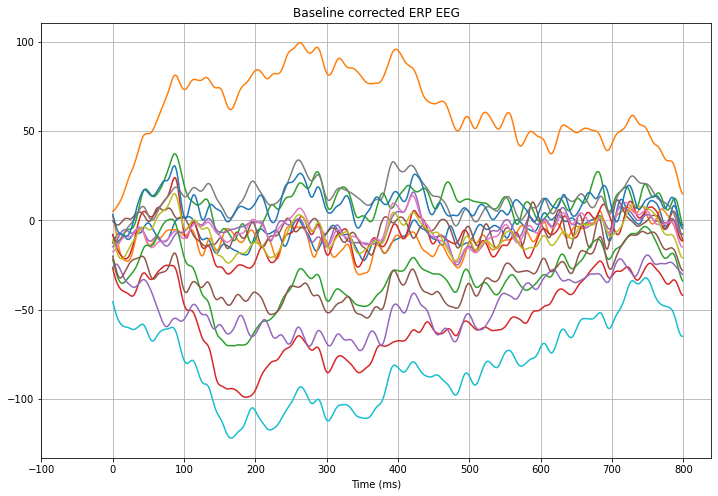

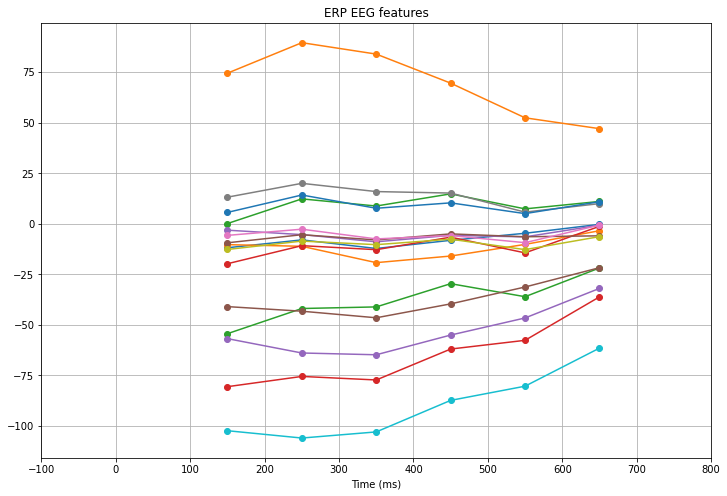

(array([[-11.85793476, -10.32500568,   0.1092874 , ..., -36.16898537,
         -31.96888883, -21.73253517],
        [ -8.44473274, -11.21992787,  19.81627436, ..., -41.75748865,
         -32.38005259, -24.54963351],
        [ -9.35402308, -17.53182981,  13.30314865, ..., -47.53468779,
         -32.49422877, -20.10510051],
        ...,
        [-43.26170575, -56.34767738, -30.63406749, ..., -21.7610524 ,
         -16.27060781, -26.61366392],
        [-37.01533042, -45.16307223, -26.32459002, ..., -21.52604808,
         -17.58027891, -30.26404138],
        [-34.41025675, -56.42143379, -33.6053337 , ..., -22.68312715,
         -18.78722476, -35.09994073]]),
 array([1, 1, 1, ..., 0, 1, 1], dtype=uint8))

In [ ]:
print(train_x.shape)

train_data = data['EEG_ERP_train']

train_x = train_data['x'][0][0]
train_y = train_data['y_dec'][0][0].reshape(-1) - 1
train_t = train_data['t'][0][0].reshape(-1)


get_erp_features(train_x, train_y, train_t, show=True)

In [ ]:
selected_channels = [12, 16, 33, 34, 28, 7, 29, 44, 41, 25, 11, 42, 14, 5, 17, 21]

print('Channels: ', end='')
for i in range(len(selected_channels)):
    selected_channels[i] -= 1

    print(train_data['chan'][0][0][0, selected_channels[i]][0], end=', ')

Channels: T7, T8, FC3, FC4, PO9, F8, O1, POz, CP4, Pz, FC6, P1, Cz, Fz, TP9, CP6, 